In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/bm/fix-mie/examples/LodeSTAR/05.track_PhC-C2DL-PSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [2]:

import deeptrack as dt
import numpy as np
import skimage.color
import matplotlib.pyplot as plt

(-0.5, 41.5, 41.5, -0.5)

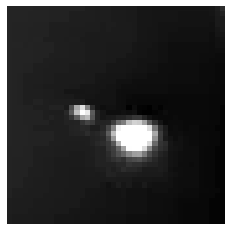

In [3]:
t, x, y, w = (0, 657, 437, 42)
training_image = dt.LoadImage(f"data/PhC-C2DL-PSC/t{t:03d}.tif")()._value / 256
crop = training_image[y:y+w, x:x+w]
plt.imshow(crop, cmap="gray")
plt.axis("off")


In [46]:
def pretrain_loss(T, P):
    diff_x = (P[:, 1:, :, 0] - P[:, :-1, :, 0] + 2) ** 2
    diff_y = (P[:, :, 1:, 1] - P[:, :, :-1, 1] + 2) ** 2

    diff_x[diff_x > 1] = 1
    diff_y[diff_y > 1] = 1

    diff_x = diff_x.mean()
    diff_y = diff_y.mean()

    return diff_x + diff_y




In [4]:

model = dt.models.LodeSTAR(input_shape=(None, None, 1))

train_set =   (
    dt.Value(crop)
    >> dt.Affine(rotate=lambda: np.random.rand()*np.pi*2, scale=lambda:np.random.uniform(0.75, 1.5, 2))
    >> dt.Add(lambda: np.random.randn() * 0.2)
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01))  
    >> dt.Multiply(lambda: np.random.uniform(0.3, 1.6))
    
)

model.fit(
    train_set,
    epochs=30,
    batch_size=8,
)



Generating 172 / 160 samples before starting training
Epoch 1/30
172/172 [==============================] - 3s 8ms/step - total_loss: 3.0493 - consistency_loss: 1.5681
Epoch 2/30
172/172 [==============================] - 2s 12ms/step - total_loss: 1.9856 - consistency_loss: 1.0564
Epoch 3/30
172/172 [==============================] - 2s 12ms/step - total_loss: 0.4137 - consistency_loss: 0.1638
Epoch 4/30
172/172 [==============================] - 2s 12ms/step - total_loss: 0.1812 - consistency_loss: 0.0438
Epoch 5/30
172/172 [==============================] - 2s 12ms/step - total_loss: 0.1351 - consistency_loss: 0.0363
Epoch 6/30
172/172 [==============================] - 2s 12ms/step - total_loss: 0.1239 - consistency_loss: 0.0346
Epoch 7/30
172/172 [==============================] - 2s 11ms/step - total_loss: 0.2084 - consistency_loss: 0.0691
Epoch 8/30
172/172 [==============================] - 2s 12ms/step - total_loss: 0.1063 - consistency_loss: 0.0291
Epoch 9/30
172/172 [=======

6.0009268e-05


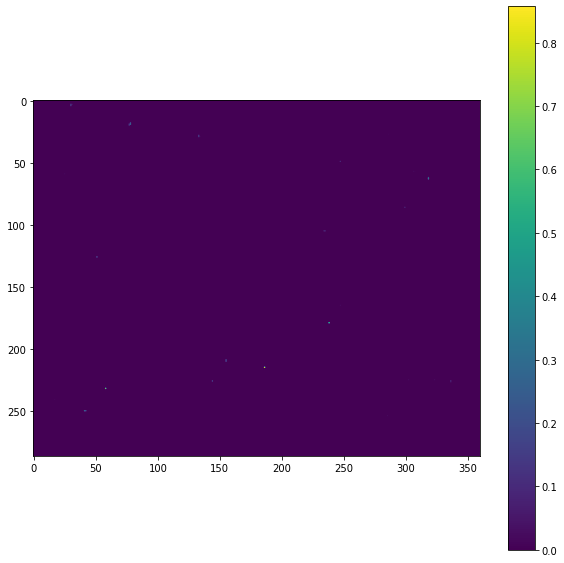

In [44]:
#May need to tune these to get optimal performance!
alpha = 1
cutoff = 0.93

frame_index = 299

image = (dt.LoadImage(f"data/PhC-C2DL-PSC/t{frame_index:03d}.tif"))()._value / 256

Y = model.model.model.predict(image[np.newaxis])

# plt.figure(figsize=(10, 10))
# plt.imshow(Y[0, ..., 0])
# plt.show()

# plt.figure(figsize=(10, 10))
# plt.imshow(Y[0, ..., 1])
# plt.show()

# plt.figure(figsize=(10, 10))
# plt.imshow(Y[0, ..., 2])
# plt.show()

E1 = np.diff(Y[0, ..., 0], axis=0)
E2 = np.diff(Y[0, ..., 1], axis=1)
W = Y[0, ..., 2]
W = np.clip(W, -20, 20)

sigmoid_w = 1 / (1 + np.exp(-W))

error = (E1 + 2) ** 2 * W[1:]
error = np.clip(error , 0, 2)
print(error.mean())


plt.figure(figsize=(10, 10))
plt.imshow(error)
plt.colorbar()
# detections = model.predict_and_detect(image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]
# # detections = autotracker.detect(pred[0], weights[0], beta=1-alpha, alpha=alpha, cutoff=cutoff, mode="constant")

# plt.figure(figsize=(15, 15))
# plt.imshow(image)
# plt.axis("off")
# plt.scatter(detections[:, 1], detections[:, 0], s=50, linewidths=4, facecolors="none", edgecolors="r")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-49-b7df9a88e304>:33: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


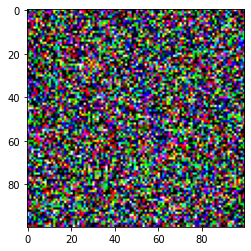

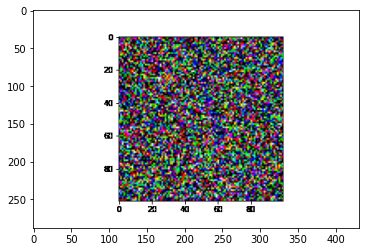

In [49]:
import imageio

video = np.random.randn(100, 100, 100, 3)

# save video as gif

def save_video_as_gif(video, filename):
    """
    Save video as gif
    
    Parameters
    ----------
    video : ndarray
        Video to save
    filename : str
        Filename to save as"""
    imageio.mimsave(filename, video, fps=10)

def convert_figure_to_ndarray(fig):
    """
    Convert figure to ndarray
    
    Parameters
    ----------
    fig : matplotlib.figure
        Figure to convert
    
    Returns
    -------
    ndarray
        Figure as ndarray"""
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data

plt.imshow(video[0])
array = convert_figure_to_ndarray(plt.gcf())
plt.show()

plt.imshow(array)
plt.show()